In [1]:
import time
import os
import random
import numpy as np     
import math

import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

from deap import base
from deap import creator
from deap import tools

import random
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


import gym
from gymnasium import spaces

from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

from scipy.ndimage import rotate

In [2]:
sys.path.append('../../../../../ocean_intella/ocean_intella/pipelay_vessel_design_optimisation_using_genetic_algorithms/')

In [3]:
import elitism

In [4]:
from scipy.spatial import ConvexHull

In [5]:
import networkx as nx

In [6]:
x0,y0 = 10, 10

# FEM Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

# Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 6000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0    

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=-1))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    try:
        tmp, const = fast_stopt(args, x)
        if const>(55+binatodeci(individual[-4:]))/100:
            return PENALTY_VALUE, 
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [28]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [29]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).astype(np.float64).reshape(x0,y0)
    
    args = get_args(*mbb_beam(rd=-1))
    print(fast_stopt(args, x))
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    
    return x

gen	nevals	min   	avg        
0  	300   	40.597	1.06682e+06
1  	247   	40.597	700.548    
2  	252   	40.597	615.067    
3  	253   	40.597	142.701    
4  	255   	39.3084	164.824    
5  	248   	35.7276	147.409    
6  	246   	35.7276	109.762    
7  	235   	35.7276	118.618    
8  	248   	34.113 	134.151    
9  	241   	31.655 	118.004    
10 	241   	31.2711	153.032    
11 	242   	29.4082	144.237    
12 	249   	27.0919	120.089    
13 	246   	25.8896	102.272    
14 	226   	25.8896	106.919    
15 	251   	25.8896	105.909    
16 	250   	25.3352	143.813    
17 	254   	24.4339	133.48     
18 	244   	23.4157	132.494    
19 	248   	23.4157	170.547    
20 	241   	23.4157	160.353    
21 	230   	22.9005	127.399    
22 	239   	22.8485	172.15     
23 	258   	22.7728	174.982    
24 	236   	22.6288	141.892    
25 	250   	22.3473	183.787    
26 	248   	22.3369	183.493    
27 	254   	21.6602	202.927    
28 	248   	21.5688	205.944    
29 	229   	21.5688	143.855    
30 	238   	21.3615	182.639    
31 	244   	21

264	242   	19.2874	35.6784    
265	251   	19.2874	39.074     
266	240   	19.2874	32.442     
267	248   	19.2874	39.041     
268	247   	19.2874	45.5068    
269	242   	19.2874	55.3366    
270	245   	19.2874	38.9584    
271	258   	19.2874	35.8118    
272	252   	19.2874	42.2612    
273	246   	19.2874	42.2194    
274	245   	19.2874	35.6899    
275	256   	19.2874	55.3159    
276	243   	19.2874	45.4903    
277	249   	19.2874	35.6999    
278	251   	19.2874	45.4995    
279	250   	19.2874	42.2226    
280	250   	19.2874	42.2865    
281	245   	19.2874	45.531     
282	250   	19.2874	29.1999    
283	248   	19.2874	32.4769    
284	242   	19.2874	38.9269    
285	242   	19.2874	48.7638    
286	254   	19.2874	45.5988    
287	240   	19.2874	52.0831    
288	243   	19.2874	29.216     
289	241   	19.2874	45.485     
290	247   	19.2874	61.8858    
291	232   	19.2874	42.288     
292	239   	19.2874	35.6877    
293	249   	19.2874	39.0666    
294	256   	19.2874	58.6116    
295	254   	19.2874	42.2645    
296	240 

529	243   	19.2725	35.6755    
530	254   	19.2725	38.9728    
531	253   	19.2725	38.9934    
532	247   	19.2725	25.9073    
533	252   	19.2725	38.9445    
534	245   	19.2725	42.2527    
535	238   	19.2725	74.9912    
536	258   	19.2725	52.0711    
537	240   	19.2725	42.2475    
538	232   	19.2725	39.0362    
539	246   	19.2725	35.6635    
540	249   	19.2725	29.158     
541	249   	19.2725	42.2685    
542	235   	19.2725	48.7488    
543	237   	19.2725	48.8037    
544	243   	19.2725	52.0197    
545	247   	19.2725	42.2574    
546	247   	19.2725	52.0335    
547	254   	19.2725	45.6384    
548	243   	19.2725	42.2478    
549	229   	19.2725	38.993     
550	254   	19.2725	48.7621    
551	241   	19.2725	61.8853    
552	255   	19.2725	42.2854    
553	255   	19.2725	45.5005    
554	251   	19.2725	35.685     
555	242   	19.2725	38.9748    
556	254   	19.2725	38.9641    
557	240   	19.2725	45.5054    
558	236   	19.2725	22.7249    
559	250   	19.2725	29.1514    
560	250   	19.2725	32.4193    
561	254 

794	247   	19.2725	71.675     
795	239   	19.2725	45.5279    
796	252   	19.2725	39.0135    
797	240   	19.2725	45.4618    
798	245   	19.2725	29.1916    
799	236   	19.2725	38.982     
800	253   	19.2725	25.945     
801	251   	19.2725	39.0032    
802	254   	19.2725	45.4987    
803	253   	19.2725	42.2025    
804	242   	19.2725	55.3419    
805	247   	19.2725	48.7424    
806	246   	19.2725	42.2295    
807	256   	19.2725	48.8056    
808	244   	19.2725	25.8936    
809	249   	19.2725	39.0177    
810	243   	19.2725	32.4403    
811	252   	19.2725	32.3989    
812	243   	19.2725	55.27      
813	234   	19.2725	35.7312    
814	247   	19.2725	32.4478    
815	250   	19.2725	38.9896    
816	249   	19.2725	32.4905    
817	242   	19.2725	52.0474    
818	238   	19.2725	29.2262    
819	245   	19.2725	39.0132    
820	239   	19.2725	58.5835    
821	243   	19.2725	48.8249    
822	243   	19.2725	48.7741    
823	242   	19.2725	45.4886    
824	243   	19.2725	35.6803    
825	248   	19.2725	45.5211    
826	240 

1057	248   	19.2725	42.2764    
1058	237   	19.2725	42.2328    
1059	246   	19.2725	45.4719    
1060	252   	19.2725	52.0446    
1061	251   	19.2725	38.915     
1062	240   	19.2725	32.4662    
1063	249   	19.2725	45.5548    
1064	236   	19.2725	35.7354    
1065	243   	19.2725	45.5949    
1066	255   	19.2725	55.3179    
1067	247   	19.2725	52.049     
1068	244   	19.2725	42.2311    
1069	245   	19.2725	35.699     
1070	245   	19.2725	35.6568    
1071	245   	19.2725	58.5735    
1072	239   	19.2725	42.2509    
1073	246   	19.2725	61.8299    
1074	246   	19.2725	48.8116    
1075	243   	19.2725	58.6697    
1076	228   	19.2725	32.4352    
1077	244   	19.2725	52.0629    
1078	238   	19.2725	42.2701    
1079	250   	19.2725	52.0847    
1080	240   	19.2725	35.7313    
1081	254   	19.2725	32.4034    
1082	247   	19.2725	45.5145    
1083	260   	19.2725	35.7566    
1084	256   	19.2725	32.3969    
1085	248   	19.2725	42.3621    
1086	242   	19.2725	48.8117    
1087	250   	19.2725	39.0335    
1088	242

1314	256   	19.2725	35.6716    
1315	241   	19.2725	39.0176    
1316	246   	19.2725	32.4186    
1317	253   	19.2725	22.6597    
1318	243   	19.2725	39.0503    
1319	248   	19.2725	42.2279    
1320	245   	19.2725	42.2374    
1321	243   	19.2725	45.5138    
1322	232   	19.2725	38.9122    
1323	238   	19.2725	38.9465    
1324	248   	19.2725	42.2225    
1325	246   	19.2725	45.4849    
1326	244   	19.2725	42.2256    
1327	247   	19.2725	29.1177    
1328	250   	19.2725	32.4159    
1329	250   	19.2725	35.6967    
1330	239   	19.2725	35.7447    
1331	236   	19.2725	29.1275    
1332	229   	19.2725	32.3843    
1333	254   	19.2725	48.8518    
1334	243   	19.2725	58.6606    
1335	253   	19.2725	48.8413    
1336	258   	19.2725	35.6906    
1337	244   	19.2725	32.4358    
1338	243   	19.2725	32.4777    
1339	250   	19.2725	45.5173    
1340	247   	19.2725	32.4448    
1341	255   	19.2725	38.9502    
1342	253   	19.2725	38.9518    
1343	247   	19.2725	38.9557    
1344	246   	19.2725	35.7315    
1345	246

1571	248   	19.2725	42.2282    
1572	253   	19.2725	48.8133    
1573	249   	19.2725	45.4796    
1574	250   	19.2725	58.6113    
1575	241   	19.2725	61.8596    
1576	247   	19.2725	61.8685    
1577	251   	19.2725	42.1856    
1578	246   	19.2725	35.7111    
1579	248   	19.2725	39.0125    
1580	247   	19.2725	38.9496    
1581	247   	19.2725	38.9519    
1582	245   	19.2725	58.5787    
1583	237   	19.2725	32.4307    
1584	239   	19.2725	35.6761    
1585	247   	19.2725	32.4059    
1586	247   	19.2725	42.2551    
1587	248   	19.2725	48.8728    
1588	257   	19.2725	52.0858    
1589	244   	19.2725	48.8166    
1590	252   	19.2725	38.9366    
1591	241   	19.2725	38.996     
1592	230   	19.2725	38.9706    
1593	253   	19.2725	48.7658    
1594	254   	19.2725	25.9461    
1595	251   	19.2725	32.4422    
1596	247   	19.2725	29.134     
1597	229   	19.2725	35.8225    
1598	246   	19.2725	45.5186    
1599	241   	19.2725	35.6989    
1600	250   	19.2725	25.8771    
1601	248   	19.2725	25.8919    
1602	251

1828	242   	19.2725	48.751     
1829	237   	19.2725	42.1981    
1830	246   	19.2725	35.6643    
1831	250   	19.2725	35.711     
1832	243   	19.2725	55.3513    
1833	242   	19.2725	29.2149    
1834	247   	19.2725	52.0263    
1835	252   	19.2725	45.4874    
1836	255   	19.2725	45.4644    
1837	251   	19.2725	42.2566    
1838	239   	19.2725	48.8109    
1839	243   	19.2725	25.8989    
1840	236   	19.2725	32.4001    
1841	251   	19.2725	39.0377    
1842	245   	19.2725	42.1856    
1843	249   	19.2725	42.2386    
1844	248   	19.2725	48.7505    
1845	239   	19.2725	29.1765    
1846	231   	19.2725	45.5192    
1847	247   	19.2725	65.1131    
1848	234   	19.2725	51.9959    
1849	246   	19.2725	35.6599    
1850	247   	19.2725	38.9883    
1851	235   	19.2725	38.9866    
1852	249   	19.2725	29.2208    
1853	253   	19.2725	32.3927    
1854	242   	19.2725	32.4222    
1855	245   	19.2725	35.7388    
1856	245   	19.2725	29.1631    
1857	244   	19.2725	39.1238    
1858	244   	19.2725	61.9312    
1859	239

2085	249   	19.2725	35.655     
2086	247   	19.2725	42.2195    
2087	238   	19.2725	61.8176    
2088	227   	19.2725	42.2707    
2089	256   	19.2725	45.5       
2090	239   	19.2725	45.5255    
2091	240   	19.2725	42.2372    
2092	245   	19.2725	55.3126    
2093	247   	19.2725	48.8336    
2094	240   	19.2725	32.4786    
2095	248   	19.2725	42.2303    
2096	256   	19.2725	45.5497    
2097	254   	19.2725	42.3094    
2098	259   	19.2725	35.6687    
2099	249   	19.2725	42.2369    
2100	236   	19.2725	42.238     
2101	247   	19.2725	48.7794    
2102	240   	19.2725	38.9246    
2103	256   	19.2725	32.4376    
2104	252   	19.2725	25.9171    
2105	243   	19.2725	48.8199    
2106	252   	19.2725	38.9868    
2107	243   	19.2725	29.1177    
2108	247   	19.2725	25.8605    
2109	247   	19.2725	48.8025    
2110	246   	19.2725	42.1911    
2111	239   	19.2725	29.1555    
2112	256   	19.2725	32.4626    
2113	243   	19.2725	48.7861    
2114	231   	19.2725	42.3199    
2115	246   	19.2725	32.4238    
2116	246

2342	249   	19.2725	45.5359    
2343	253   	19.2725	58.5562    
2344	247   	19.2725	32.4199    
2345	236   	19.2725	32.4773    
2346	238   	19.2725	25.8739    
2347	242   	19.2725	42.2022    
2348	243   	19.2725	22.5955    
2349	253   	19.2725	25.937     
2350	254   	19.2725	35.6743    
2351	257   	19.2725	29.1796    
2352	238   	19.2725	35.7458    
2353	251   	19.2725	35.7329    
2354	253   	19.2725	32.4939    
2355	249   	19.2725	42.2843    
2356	241   	19.2725	42.3118    
2357	252   	19.2725	35.8132    
2358	252   	19.2725	32.4108    
2359	244   	19.2725	35.6949    
2360	245   	19.2725	38.9717    
2361	254   	19.2725	45.4872    
2362	252   	19.2725	45.4866    
2363	249   	19.2725	35.692     
2364	254   	19.2725	35.7129    
2365	251   	19.2725	22.6001    
2366	252   	19.2725	39.0169    
2367	230   	19.2725	38.9511    
2368	245   	19.2725	35.6825    
2369	246   	19.2725	25.9041    
2370	238   	19.2725	38.9267    
2371	251   	19.2725	35.6707    
2372	249   	19.2725	19.3699    
2373	248

2599	245   	19.2725	52.0402    
2600	237   	19.2725	52.0101    
2601	248   	19.2725	32.4258    
2602	253   	19.2725	32.474     
2603	249   	19.2725	38.9822    
2604	252   	19.2725	38.9246    
2605	253   	19.2725	48.7774    
2606	232   	19.2725	42.2304    
2607	239   	19.2725	42.2916    
2608	244   	19.2725	48.7602    
2609	249   	19.2725	42.2144    
2610	240   	19.2725	45.4877    
2611	256   	19.2725	35.6616    
2612	239   	19.2725	52.0671    
2613	242   	19.2725	38.9639    
2614	237   	19.2725	35.7343    
2615	234   	19.2725	32.414     
2616	243   	19.2725	42.2226    
2617	251   	19.2725	42.2437    
2618	254   	19.2725	55.2776    
2619	244   	19.2725	42.2392    
2620	247   	19.2725	42.2332    
2621	240   	19.2725	42.2631    
2622	248   	19.2725	38.9801    
2623	243   	19.2725	42.2362    
2624	251   	19.2725	48.8813    
2625	240   	19.2725	38.9504    
2626	255   	19.2725	45.4706    
2627	241   	19.2725	38.9521    
2628	240   	19.2725	45.4756    
2629	254   	19.2725	48.7958    
2630	245

2856	240   	19.2725	42.2678    
2857	250   	19.2725	35.6784    
2858	239   	19.2725	38.9789    
2859	240   	19.2725	45.5815    
2860	248   	19.2725	45.5124    
2861	245   	19.2725	29.1391    
2862	237   	19.2725	52.0168    
2863	247   	19.2725	39.0268    
2864	250   	19.2725	42.2223    
2865	257   	19.2725	38.9781    
2866	244   	19.2725	32.4421    
2867	244   	19.2725	58.5951    
2868	246   	19.2725	45.5301    
2869	244   	19.2725	39.027     
2870	240   	19.2725	25.913     
2871	250   	19.2725	42.2359    
2872	242   	19.2725	25.894     
2873	250   	19.2725	32.4414    
2874	237   	19.2725	32.4642    
2875	249   	19.2725	35.7244    
2876	257   	19.2725	48.7776    
2877	243   	19.2725	32.5062    
2878	259   	19.2725	35.6737    
2879	250   	19.2725	32.4384    
2880	232   	19.2725	38.9664    
2881	258   	19.2725	45.5211    
2882	243   	19.2725	29.2635    
2883	239   	19.2725	38.9894    
2884	245   	19.2725	58.5995    
2885	252   	19.2725	52.0263    
2886	239   	19.2725	35.6772    
2887	257

3113	236   	19.2725	42.2074    
3114	235   	19.2725	48.8451    
3115	240   	19.2725	35.6508    
3116	244   	19.2725	42.2406    
3117	248   	19.2725	52.0424    
3118	241   	19.2725	45.5205    
3119	248   	19.2725	35.7431    
3120	240   	19.2725	48.7629    
3121	253   	19.2725	52.1064    
3122	245   	19.2725	32.4827    
3123	257   	19.2725	55.3073    
3124	248   	19.2725	32.4035    
3125	252   	19.2725	32.3766    
3126	237   	19.2725	42.1762    
3127	244   	19.2725	29.1815    
3128	247   	19.2725	32.4336    
3129	244   	19.2725	32.4562    
3130	257   	19.2725	29.1851    
3131	236   	19.2725	42.2318    
3132	239   	19.2725	35.6984    
3133	247   	19.2725	48.7573    
3134	253   	19.2725	38.9702    
3135	250   	19.2725	29.161     
3136	244   	19.2725	32.4543    
3137	234   	19.2725	22.6812    
3138	227   	19.2725	29.1453    
3139	244   	19.2725	32.4067    
3140	246   	19.2725	42.2332    
3141	251   	19.2725	38.9543    
3142	240   	19.2725	48.8333    
3143	257   	19.2725	38.972     
3144	242

3370	237   	19.2725	42.2063    
3371	251   	19.2725	42.1991    
3372	239   	19.2725	29.156     
3373	250   	19.2725	32.387     
3374	247   	19.2725	48.7524    
3375	246   	19.2725	55.3761    
3376	242   	19.2725	42.2853    
3377	246   	19.2725	35.8097    
3378	253   	19.2725	35.6537    
3379	240   	19.2725	35.7194    
3380	248   	19.2725	32.4357    
3381	245   	19.2725	38.9471    
3382	251   	19.2725	35.7229    
3383	232   	19.2725	55.3174    
3384	233   	19.2725	48.7405    
3385	239   	19.2725	22.6361    
3386	241   	19.2725	32.3765    
3387	244   	19.2725	55.3046    
3388	247   	19.2725	32.4699    
3389	248   	19.2725	42.253     
3390	239   	19.2725	52.1179    
3391	250   	19.2725	42.3046    
3392	248   	19.2725	48.7914    
3393	246   	19.2725	38.9258    
3394	242   	19.2725	38.9377    
3395	249   	19.2725	42.255     
3396	233   	19.2725	32.4518    
3397	246   	19.2725	45.5141    
3398	245   	19.2725	42.2101    
3399	258   	19.2725	52.0795    
3400	235   	19.2725	42.2243    
3401	257

3627	238   	19.2725	38.9423    
3628	245   	19.2725	39.0064    
3629	246   	19.2725	35.7043    
3630	242   	19.2725	45.5117    
3631	252   	19.2725	32.4348    
3632	257   	19.2725	32.4602    
3633	246   	19.2725	39.0311    
3634	246   	19.2725	39.0458    
3635	249   	19.2725	35.7266    
3636	242   	19.2725	42.3663    
3637	249   	19.2725	38.9384    
3638	231   	19.2725	32.401     
3639	249   	19.2725	58.6557    
3640	234   	19.2725	22.6569    
3641	247   	19.2725	35.6684    
3642	250   	19.2725	48.91      
3643	257   	19.2725	45.4895    
3644	249   	19.2725	38.9685    
3645	240   	19.2725	52.0535    
3646	247   	19.2725	38.9957    
3647	246   	19.2725	45.4974    
3648	241   	19.2725	19.3578    
3649	246   	19.2725	45.5367    
3650	240   	19.2725	38.9887    
3651	244   	19.2725	35.7012    
3652	245   	19.2725	48.7747    
3653	228   	19.2725	58.5879    
3654	229   	19.2725	45.5801    
3655	243   	19.2725	45.4719    
3656	261   	19.2725	55.3595    
3657	255   	19.2725	35.6672    
3658	246

3884	239   	19.2725	29.214     
3885	246   	19.2725	32.4117    
3886	247   	19.2725	55.3104    
3887	239   	19.2725	48.8247    
3888	238   	19.2725	32.4064    
3889	243   	19.2725	42.2174    
3890	242   	19.2725	42.3106    
3891	252   	19.2725	48.7249    
3892	245   	19.2725	42.2099    
3893	245   	19.2725	32.4876    
3894	245   	19.2725	35.6654    
3895	246   	19.2725	35.7284    
3896	258   	19.2725	39.0126    
3897	245   	19.2725	35.6826    
3898	256   	19.2725	32.3863    
3899	246   	19.2725	38.9679    
3900	242   	19.2725	42.1942    
3901	242   	19.2725	52.0075    
3902	250   	19.2725	42.2199    
3903	253   	19.2725	35.6798    
3904	253   	19.2725	58.5376    
3905	238   	19.2725	45.4456    
3906	252   	19.2725	45.4946    
3907	240   	19.2725	51.9979    
3908	251   	19.2725	42.2146    
3909	246   	19.2725	32.4846    
3910	255   	19.2725	35.9435    
3911	233   	19.2725	38.9893    
3912	242   	19.2725	35.7019    
3913	247   	19.2725	35.8103    
3914	248   	19.2725	35.7309    
3915	247

4141	245   	19.2725	32.4346    
4142	233   	19.2725	38.9473    
4143	234   	19.2725	42.213     
4144	253   	19.2725	35.6464    
4145	252   	19.2725	32.4386    
4146	248   	19.2725	29.1312    
4147	239   	19.2725	38.9297    
4148	254   	19.2725	35.7       
4149	236   	19.2725	32.4043    
4150	255   	19.2725	48.7454    
4151	245   	19.2725	32.4365    
4152	258   	19.2725	42.2849    
4153	228   	19.2725	38.9638    
4154	243   	19.2725	32.4092    
4155	245   	19.2725	29.1263    
4156	245   	19.2725	32.3772    
4157	243   	19.2725	29.1534    
4158	244   	19.2725	42.2742    
4159	251   	19.2725	42.2101    
4160	244   	19.2725	39.0185    
4161	235   	19.2725	35.6616    
4162	248   	19.2725	42.1959    
4163	246   	19.2725	35.755     
4164	251   	19.2725	38.9612    
4165	243   	19.2725	32.4631    
4166	252   	19.2725	32.4444    
4167	246   	19.2725	35.7103    
4168	252   	19.2725	38.9418    
4169	233   	19.2725	29.1732    
4170	238   	19.2725	29.1723    
4171	246   	19.2725	32.4565    
4172	250

4398	241   	19.2725	38.992     
4399	254   	19.2725	25.907     
4400	255   	19.2725	29.1524    
4401	249   	19.2725	29.158     
4402	250   	19.2725	38.952     
4403	248   	19.2725	32.4354    
4404	252   	19.2725	45.4768    
4405	251   	19.2725	38.9451    
4406	247   	19.2725	32.4105    
4407	255   	19.2725	35.7916    
4408	244   	19.2725	35.6723    
4409	245   	19.2725	42.2001    
4410	243   	19.2725	35.7047    
4411	254   	19.2725	42.2421    
4412	252   	19.2725	45.5181    
4413	241   	19.2725	48.7671    
4414	238   	19.2725	38.9984    
4415	247   	19.2725	38.9193    
4416	231   	19.2725	42.2345    
4417	255   	19.2725	35.7073    
4418	246   	19.2725	32.4244    
4419	238   	19.2725	42.1914    
4420	236   	19.2725	35.6839    
4421	250   	19.2725	35.6532    
4422	256   	19.2725	35.658     
4423	253   	19.2725	52.0816    
4424	255   	19.2725	42.2862    
4425	253   	19.2725	42.2442    
4426	253   	19.2725	29.1406    
4427	252   	19.2725	32.4231    
4428	251   	19.2725	52.1457    
4429	242

4655	246   	19.2725	45.6323    
4656	239   	19.2725	45.5313    
4657	237   	19.2725	45.4964    
4658	242   	19.2725	48.7475    
4659	242   	19.2725	42.2396    
4660	241   	19.2725	29.1953    
4661	244   	19.2725	39.0059    
4662	248   	19.2725	32.4048    
4663	238   	19.2725	42.1949    
4664	255   	19.2725	29.202     
4665	245   	19.2725	25.8935    
4666	251   	19.2725	38.9263    
4667	251   	19.2725	48.746     
4668	255   	19.2725	32.4203    
4669	249   	19.2725	38.9486    
4670	256   	19.2725	55.2973    
4671	243   	19.2725	29.1585    
4672	250   	19.2725	29.1632    
4673	251   	19.2725	35.6806    
4674	249   	19.2725	42.2412    
4675	249   	19.2725	25.9457    
4676	242   	19.2725	29.1865    
4677	252   	19.2725	25.8521    
4678	248   	19.2725	38.9474    
4679	257   	19.2725	32.4275    
4680	227   	19.2725	35.6612    
4681	242   	19.2725	35.6984    
4682	244   	19.2725	61.8369    
4683	248   	19.2725	35.6764    
4684	245   	19.2725	32.4427    
4685	255   	19.2725	29.1309    
4686	245

4912	237   	19.2725	29.1327    
4913	241   	19.2725	42.2179    
4914	253   	19.2725	42.2775    
4915	259   	19.2725	29.2737    
4916	247   	19.2725	45.487     
4917	253   	19.2725	42.2648    
4918	242   	19.2725	38.9839    
4919	246   	19.2725	25.8621    
4920	244   	19.2725	52.0087    
4921	243   	19.2725	48.823     
4922	246   	19.2725	39.0007    
4923	244   	19.2725	45.532     
4924	248   	19.2725	42.2603    
4925	245   	19.2725	35.6804    
4926	244   	19.2725	42.1989    
4927	244   	19.2725	42.2256    
4928	238   	19.2725	22.6074    
4929	245   	19.2725	35.669     
4930	248   	19.2725	42.2249    
4931	236   	19.2725	38.9598    
4932	248   	19.2725	25.9118    
4933	242   	19.2725	38.9377    
4934	246   	19.2725	35.689     
4935	248   	19.2725	29.1521    
4936	250   	19.2725	38.9412    
4937	244   	19.2725	39.0305    
4938	247   	19.2725	42.2367    
4939	240   	19.2725	35.6648    
4940	240   	19.2725	32.4856    
4941	234   	19.2725	38.9798    
4942	249   	19.2725	39.0137    
4943	257

5169	252   	19.2725	42.2466    
5170	255   	19.2725	29.1454    
5171	251   	19.2725	61.8304    
5172	241   	19.2725	32.4068    
5173	240   	19.2725	38.9126    
5174	250   	19.2725	48.9074    
5175	247   	19.2725	25.8967    
5176	237   	19.2725	25.9034    
5177	243   	19.2725	32.4307    
5178	252   	19.2725	42.2907    
5179	250   	19.2725	42.259     
5180	243   	19.2725	38.9646    
5181	238   	19.2725	35.7012    
5182	246   	19.2725	35.7238    
5183	254   	19.2725	38.9524    
5184	245   	19.2725	45.5108    
5185	253   	19.2725	48.7583    
5186	251   	19.2725	52.0034    
5187	235   	19.2725	29.1823    
5188	252   	19.2725	52.0597    
5189	236   	19.2725	35.7488    
5190	246   	19.2725	35.6544    
5191	257   	19.2725	45.5161    
5192	255   	19.2725	52.047     
5193	233   	19.2725	35.676     
5194	247   	19.2725	48.7533    
5195	252   	19.2725	32.4445    
5196	240   	19.2725	32.4747    
5197	244   	19.2725	32.4149    
5198	247   	19.2725	38.9269    
5199	251   	19.2725	55.2943    
5200	249

5426	249   	19.2725	35.7383    
5427	241   	19.2725	35.6661    
5428	245   	19.2725	32.4567    
5429	249   	19.2725	35.6941    
5430	245   	19.2725	32.4129    
5431	249   	19.2725	42.2305    
5432	246   	19.2725	42.2419    
5433	252   	19.2725	42.2432    
5434	250   	19.2725	52.1872    
5435	254   	19.2725	42.2403    
5436	244   	19.2725	22.6142    
5437	235   	19.2725	35.7779    
5438	244   	19.2725	35.656     
5439	246   	19.2725	35.6863    
5440	234   	19.2725	32.5394    
5441	250   	19.2725	35.6986    
5442	243   	19.2725	32.4955    
5443	248   	19.2725	42.4317    
5444	252   	19.2725	48.742     
5445	243   	19.2725	35.7343    
5446	251   	19.2725	45.5236    
5447	252   	19.2725	48.8409    
5448	258   	19.2725	42.3446    
5449	242   	19.2725	35.737     
5450	243   	19.2725	29.2294    
5451	250   	19.2725	48.8845    
5452	254   	19.2725	29.1756    
5453	246   	19.2725	38.9717    
5454	250   	19.2725	25.893     
5455	247   	19.2725	32.4202    
5456	247   	19.2725	35.8058    
5457	250

5683	249   	19.2725	35.7224    
5684	241   	19.2725	39.0471    
5685	237   	19.2725	42.2308    
5686	251   	19.2725	38.9663    
5687	246   	19.2725	38.9489    
5688	252   	19.2725	45.5575    
5689	237   	19.2725	25.8797    
5690	251   	19.2725	42.2724    
5691	228   	19.2725	35.6774    
5692	245   	19.2725	48.7664    
5693	232   	19.2725	32.4097    
5694	227   	19.2725	48.7717    
5695	247   	19.2725	29.1094    
5696	250   	19.2725	35.6601    
5697	248   	19.2725	48.7728    
5698	249   	19.2725	39.0004    
5699	246   	19.2725	48.8429    
5700	253   	19.2725	32.4054    
5701	242   	19.2725	45.5783    
5702	241   	19.2725	38.969     
5703	252   	19.2725	48.7889    
5704	246   	19.2725	48.7416    
5705	244   	19.2725	29.2238    
5706	249   	19.2725	48.7832    
5707	252   	19.2725	48.916     
5708	244   	19.2725	42.2435    
5709	238   	19.2725	45.4809    
5710	251   	19.2725	38.9572    
5711	245   	19.2725	29.1429    
5712	245   	19.2725	38.9323    
5713	253   	19.2725	42.2673    
5714	243

5940	236   	19.2725	45.4902    
5941	247   	19.2725	38.9651    
5942	240   	19.2725	35.6629    
5943	246   	19.2725	29.1172    
5944	247   	19.2725	38.945     
5945	247   	19.2725	38.9696    
5946	246   	19.2725	29.223     
5947	250   	19.2725	45.5336    
5948	240   	19.2725	39.1894    
5949	226   	19.2725	45.4582    
5950	246   	19.2725	32.4044    
5951	253   	19.2725	45.4794    
5952	245   	19.2725	38.9402    
5953	254   	19.2725	35.6661    
5954	245   	19.2725	29.1881    
5955	250   	19.2725	22.5952    
5956	247   	19.2725	35.7138    
5957	249   	19.2725	38.9573    
5958	243   	19.2725	48.7554    
5959	242   	19.2725	35.6776    
5960	254   	19.2725	35.6676    
5961	246   	19.2725	65.0997    
5962	246   	19.2725	42.2718    
5963	249   	19.2725	52.0222    
5964	240   	19.2725	42.2333    
5965	254   	19.2725	35.6623    
5966	254   	19.2725	32.4532    
5967	246   	19.2725	42.2102    
5968	257   	19.2725	29.1519    
5969	246   	19.2725	38.9931    
5970	248   	19.2725	32.3863    
5971	245

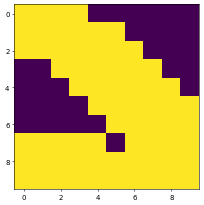

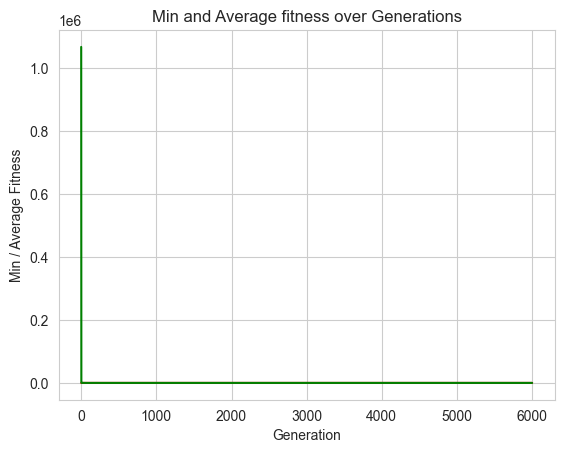

In [30]:
start = time.time()
top_=main()
end = time.time() 

In [31]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 35.46729464928309 min
